# Tarea 5

**Envío del PR inicial:** 15 de octubre

**Aceptación del PR:** 21 de octubre

NOTA: Esta tarea debe entregarse en equipo.

## 1

Llamemos $c_n$ el valor del parámetro $c$ donde ocurre la bifurcación de doblamiento de periodo para el mapeo $Q_c(x)=x^2+c$, donde la órbita de periodo $2^n$ nace. Como hemos visto en notebooks anteriores, tenemos que $c_0=1/4$ marca la aparición del atractor de periodo $2^0=1$, $c_1=-1/4$ corresponde a la aparición del atractor de periodo $2^1=2$, $c_2=-3/4$ a la aparición del atractor de periodo $2^2=4$, etc. 

A partir de estos valores y otros que calcularán (al menos deben encontrar $c_6$), definimos la secuencia: $\{f_0, f_1, f_2, \dots\}$, donde

\begin{equation}
f_n = \frac{c_n-c_{n+1}}{c_{n+1}-c_{n+2}} .
\end{equation}

La pregunta es, ¿a qué valor converge esta secuencia?, es decir, dar una estimación de $f_\infty$.


*Hint:* Para realizar este ejercicio deben calcular el atractor para varios valores de $c$, de tal manera que puedan aislar las órbitas de periodo $2^p$ y de ahí determinar varios valores $c_n$. Se requerir suficiente cuidado para obtener una buena aproximación de $c_n$. 
Una opción se basa en recordar/usar que las bifurcaciones de doblamiento de periodo ocurren cuando los puntos de la órbita de periodo $p$ se tornan en repulsores, es decir, $(Q_c^p)'(x)=-1$. Esta opción, entonces, involucra obtener los valores $c_n$ a partir de órbitas periódicas de periodo $2^n$ usando los polinomios $Q_c^{2^p}(x)$ y diferenciación automática.

In [4]:
using LaTeXStrings
using PyPlot

Agregaremos un par de herramientas de notebooks anteriores.

In [5]:
#"Módulo" Diferenciación Automática
import Base: +, -, *, /, ^
import Base.show
import Base: sqrt, exp, log, sin, cos, sinh, cosh

"""
    Dual

Definición de los números duales. Los campos internos son
    x  :: Float64   # valor de la función
    x′ :: Float64   # valor de su derivada

"""
struct Dual
    x  :: Float64
    x′ :: Float64
end

Dual(c::Real) = Dual(c, 0.0)
dual(x0::Real) = Dual(x0, 1.0)

+(u::Dual, v::Dual) = Dual( u.x + v.x, u.x′ + v.x′)

-(u::Dual, v::Dual) = Dual( u.x - v.x, u.x′ - v.x′)

*(u::Dual, v::Dual) = Dual( u.x * v.x, u.x * v.x′ + u.x′ * v.x)

function /(u::Dual, v::Dual)
    y = u.x / v.x
    Dual( y, (u.x′ - y * v.x′)/v.x )
end

function ^(a::Dual, n::Int)
    y = a.x^(n-1)
    Dual(a.x * y, n*y*a.x′)
end

#+
+(a::Real, u::Dual) = Dual( a + u.x, u.x′)
+(u::Dual, a::Real) = Dual( a + u.x, u.x′)
#-
-(a::Real, u::Dual) = Dual( a - u.x, -u.x′)
-(u::Dual, a::Real) = Dual( u.x - a, u.x′)
#*
*(a::Real, u::Dual) = Dual(u.x*a,u.x′*a)
*(u::Dual, a::Real) = Dual(u.x*a,u.x′*a)
#/
function /(a::Real,u::Dual)
    y = a / u.x
    Dual( y, (-y * u.x′)/u.x )
end
/(u::Dual, a::Real)=Dual( u.x/a, u.x′/a )

function show(u::Dual)
    print(string(u.x)*" + "*string(u.x′)*"ε")
end

sqrt(u::Dual)=Dual(sqrt(u.x),u.x′/(2*sqrt(u.x)))
exp(u::Dual)=Dual(exp(u.x),u.x′*exp(u.x))
log(u::Dual)=Dual(log(u.x),u.x′/u.x)
sin(u::Dual)=Dual(sin(u.x),u.x′*cos(u.x))
cos(u::Dual)=Dual(cos(u.x),-u.x′*sin(u.x))
sinh(u::Dual)=Dual(sinh(u.x),u.x′*cosh(u.x))
cosh(u::Dual)=Dual(cosh(u.x),u.x′*sinh(u.x))

"Método de Newton con Duales a partir de una función real f y un valor inicial x=0."
function newton(f,x0,tol=1e-15)
    fprime(x)=f(dual(x)).x′
    xn=x0
    while abs(f(xn))>tol
        xn=xn-f(xn)/fprime(xn)
    end
    return xn
end

"A partir de una función real f, y un rango x0, devuelven las raíces encontradas"
function soluciones(f,x0)
    raiz=[]
    raices=[]
    for i in x0
        r=newton(f,i)
        if abs(r)≠Inf
            push!(raiz,r)
        end
    end
    push!(raices,raiz[1])
    for i in 1:size(raiz,1)-1
        if abs(raiz[i]-raiz[i+1])>1e-10
            a=true
            b=true
            for j in raices
                if abs(raiz[i+1]-j)>1e-10
                    a=true
                else
                    a=false
                b=(a & b)
                end
            end
            if b==true
                push!(raices,raiz[i+1])
            end
        end
    end
    return raices
end

soluciones

Utilizaremos un par de funciones correspondientes al notebook 6.

In [6]:
"""
    ciclosestables!(xx, f, cc, nit, nout)

Esta función itera el mapeo `f`, de una variable, `nit+nout` veces, 
usando como condición inicial `x0=0`; los últimos `nout` iterados 
actualizan al vector `xx` que tiene longitud `nout`. `cc` es el valor
del parámetro del mapeo `f`. El mapeo `f` debe ser definido de 
tal manera que `f(x0, cc)` tenga sentido. La idea es que los últimos 
`nout` iterados reflejen los ciclos estables del mapeo `f`.
"""
function ciclosestables!(xx, f, cc, nit, nout)
    @assert (nit > 0) && (nout > 0)
    
    x0=0.01
    # Primeros nit iterados
    for it = 1:nit
        x0 = f(x0, cc)
    end
    
    # Se guardan los siguientes nout iterados
    for it = 1:nout
        x0 = f(x0, cc)
        @inbounds xx[it] = x0
    end
    
    nothing
end

"""
    diag_bifurc(f, nit, nout, crange)

Itera el mapeo `f` `nit+nout` veces y regresa una matriz
cuya columna `i` tiene los últimos `nout` iterados del mapeo
para el valor del parámetro del mapeo `crange[i]`.

La función `f` debe ser definida de tal manera que `f(x0, c)` 
tenga sentido.
"""
function diag_bifurc(f, nit, nout, crange)
#     xx = Vector{Float64}(nout)
    ff = Array{Float64,2}(nout, length(crange))
    
    for ic in eachindex(crange)
        c = crange[ic]
        ciclosestables!(view(ff, :, ic), f, c, nit, nout)
#         ff[:,ic] = xx
    end
    
    return ff
end

diag_bifurc

In [7]:
Qc(x,c) = x^2 + c

crange = 0.25:-1/2^10:-2.0

ff = diag_bifurc(Qc, 100000, 256, crange); 
cc = ones(size(ff, 1)) * crange';

# Esto cambia las matrices en vectores; ayuda un poco para los dibujos
ff = reshape(ff, size(ff, 1)*size(ff, 2));
cc = reshape(cc, size(ff));

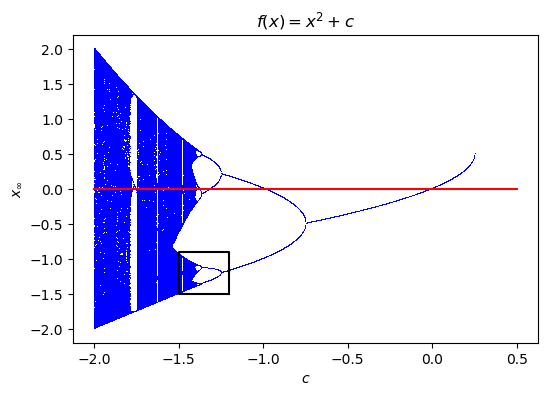

In [8]:
figure(figsize=(6,4))
plot(cc, ff, "b,")
plot([-1.2,-1.5,-1.5,-1.2,-1.2], [-1.5,-1.5,-0.9,-0.9,-1.5], "k-")
plot([-2,0.5], [0.0,0.0], "r-")
xlabel(L"c")
ylabel(L"x_\infty")
title(L"f(x)=x^2+c")
show()

Para $c_1$=-0.25

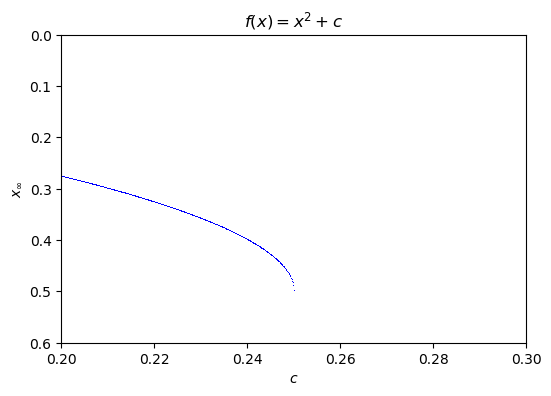

In [9]:
Qc(x,c) = x^2 + c

crange = 0.25:-1/2^13:0

ff = diag_bifurc(Qc, 100000, 256, crange); 
cc = ones(size(ff, 1)) * crange';
ff = reshape(ff, size(ff, 1)*size(ff, 2));
cc = reshape(cc, size(ff));

figure(figsize=(6,4))
plot(cc, ff, "b,")
xlabel(L"c")
ylabel(L"x_\infty")
title(L"f(x)=x^2+c")
xlim(0.20,0.30)
ylim(0.6,0)
show()

Para $c_1$= - 0.75:

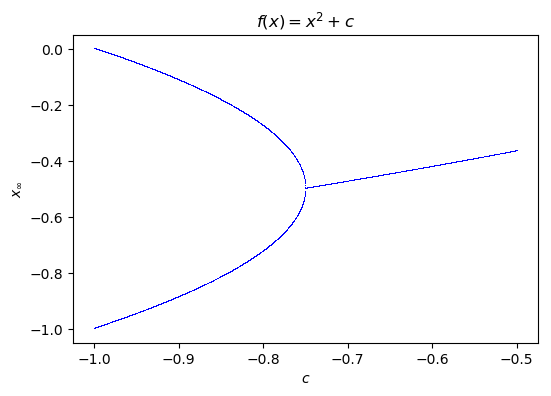

In [10]:
Qc(x,c) = x^2 + c

crange = -1:1/2^13:-0.5


ff = diag_bifurc(Qc, 100000, 256, crange); 
cc = ones(size(ff, 1)) * crange';
ff = reshape(ff, size(ff, 1)*size(ff, 2));
cc = reshape(cc, size(ff));

figure(figsize=(6,4))
plot(cc, ff, "b,")
xlabel(L"c")
ylabel(L"x_\infty")
title(L"f(x)=x^2+c")
show()

A continuación se hace un zoom:

Para $c_2$= - 1.25 :

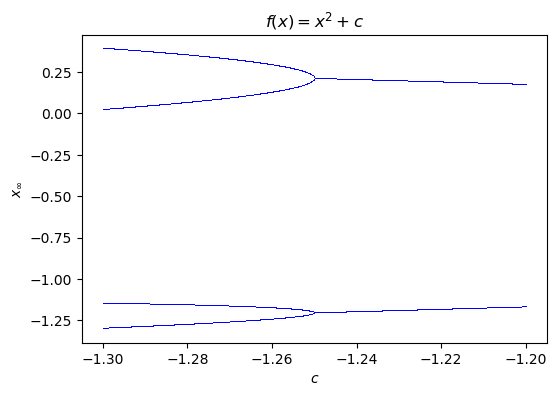

In [11]:
Qc(x,c) = x^2 + c

crange = -1.3:1/2^13:-1.2

ff = diag_bifurc(Qc, 100000, 256, crange); 
cc = ones(size(ff, 1)) * crange';
ff = reshape(ff, size(ff, 1)*size(ff, 2));
cc = reshape(cc, size(ff));

figure(figsize=(6,4))
plot(cc, ff, "b,")
xlabel(L"c")
ylabel(L"x_\infty")
#xlim(-1.24,-1.26)
#ylim(-1.150,-1.3)
title(L"f(x)=x^2+c")
show()

In [ ]:
"""Esta función nos da un vector con los valores aproximados de la derivada en una vecindad al punto de bifurcación."""
function derivada_bifurcacion(f,c,p;tol=1e-16,nit=1000000)
    mapeo = diag_bifurc(f, nit, p, [c[1]])
    s=c[1]-c[2]
    h = dual(mapeo[1,1])
        for k in 1:p
            h = f(h, c[1])
        end
    
    ev1=1-abs(h.x′)
    ev2=1-abs(h.x′)
    H=[]
    
    for i in c
        mapeo = diag_bifurc(f, nit, p, [i])
        h = dual(mapeo[1,1])
        for k in 1:p
            h = f(h, i)
        end
        push!(H,h.x′)
    end
    return H
end

In [12]:
"""Esta función nos permite obtener una buena aproximación del valor de c para el cuál ocurre el doblamiento de periodo, 
tomando como parámetro la función, el intervalo dentro del que se encuentra el doblamiento de periodo y "p", el número 
de iteraciones."""
function doblamiento_periodo(f,c,p;tol=1e-16,nit=1000000)
    mapeo = diag_bifurc(f, nit, p, [c[1]])
    s=c[1]-c[2]
    h = dual(mapeo[1,1])
        for k in 1:p
            h = f(h, c[1])
        end
    
    ev1=1-abs(h.x′)
    ev2=1-abs(h.x′)
    
    for i in c
        if(ev1*ev2 > tol)
            mapeo = diag_bifurc(f, nit, p, [i])
            h = dual(mapeo[1,1])
            for k in 1:p
                h = f(h, i)
            end
        else
            return i+s
            break
        end
        ev1=ev2
        ev2=1-abs(h.x′)
    end
end

doblamiento_periodo

Conforme c decrece, existe una sucesión de bifurcaciones de doblamiento de periodo. Que aparecen en el orden: $1, 2, 4, 8,..., 2^n, ...$

In [13]:
Q(x,c)=x^2+c

Q (generic function with 1 method)

In [14]:
doblamiento_periodo(Q,-1.24:-1/10^5:-1.26,2)

-1.25

In [15]:
#doblamiento_periodo(Q,-1.36:-1/10^7:-1.37,4)

-1.3680976000000002

In [16]:
#doblamiento_periodo(Q,-1.391:-1/10^7:-1.395,8)

In [17]:
#doblamiento_periodo(Q,-1.395:-1/10^7:-1.4,16)

In [18]:
#doblamiento_periodo(Q,-1.4:-1/10^8:-1.405,32)

In [19]:
#doblamiento_periodo(Q,-1.3901:-1/10^7:-1.42,64)

Entonces: $c_0=  0.25 ,c_1= - 0.75, c_2= - 1.25, c_3= - 1.3680976, c_4= - 1.3940457, c_5= -1.3996311, c_6= -1.40116863, c_7= -1.4011480$

Definimos la secuencia: $\{f_0, f_1, f_2, \dots\}$, donde

\begin{equation}
f_n = \frac{c_n-c_{n+1}}{c_{n+1}-c_{n+2}} .
\end{equation}

In [20]:
function fn(cn,cn1,cn2)
fn=(cn-cn1)/(cn1-cn2)
end

fn (generic function with 1 method)

In [21]:
fn(0.25,-0.75,-1.25)

2.0

In [22]:
fn(-0.75,-1.25,- 1.368098)

4.2337719521075705

In [23]:
fn(-1.25,- 1.3680976,- 1.3940457)

4.551300480574701

In [24]:
C=[0.25,-0.75,-1.25,- 1.3680976,- 1.3940457,-1.3996311,-1.40116836,-1.4011479999999998]

for i in 1:6
    A=fn(C[i],C[i+1],C[i+2])
    println(A)
end

2.0
4.233786292016094
4.551300480574701
4.645701292655869
3.633347644510112
-75.50392927248255


Esta secuencia de números converge a la llamada constante de Feigenbaum: $ 4.669201609... $ .Usualmente también es expresada como:

$ \delta = lim_{n-> \infty} \frac{a_{n-1}  \ - \ a_{n-2}}{a_n \ - \ a_{n-1}} = 4.669201609... $

Sorprendentemente, este límite es el mismo para cualquier familia de mapeos unidimensionales con un solo parámetro. Dicho de otro modo esta constante es universal en el sentido de que aplica para una variedad de sistemas dinámicos.

## 2

Repitan el ejercicio anterior para el mapeo $S_c(x) = c \sin(x)$. 

- ¿Cómo se comparan los valores obtenidos de $f_n$? 

- ¿Qué interpretación le pueden dar a este resultado, en comparación del ejercicio anterior?

In [25]:
Sc(x,c)=c*sin(x)

crange = -3:1/7^3:3

ff = diag_bifurc(Sc, 100000, 256, crange); 
cc = ones(size(ff, 1)) * crange';
ff = reshape(ff, size(ff, 1)*size(ff, 2));
cc = reshape(cc, size(ff));

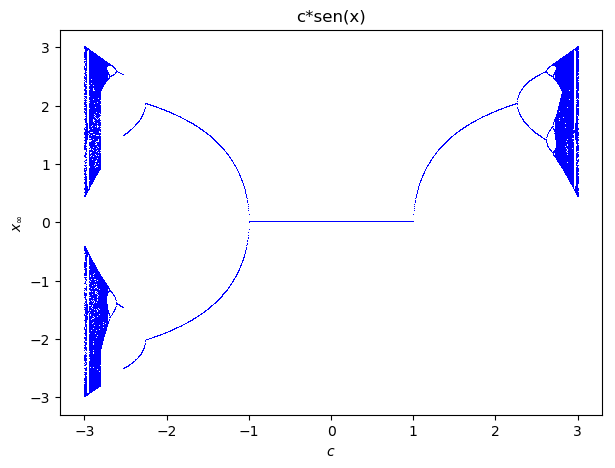

PyObject Text(0.5,1,'c*sen(x)')

In [31]:
figure(figsize=(7,5))
plot(cc, ff, "b,")
xlabel(L"c")
ylabel(L"x_\infty")
title("c*sen(x)")

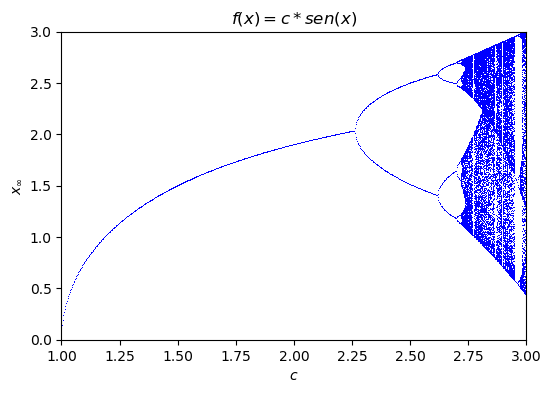

In [27]:
figure(figsize=(6,4))
plot(cc, ff, "b,")
xlabel(L"c")
ylabel(L"x_\infty")
title(L"f(x)=c*sen(x)")
xlim(1,3)
ylim(0,3)
show()

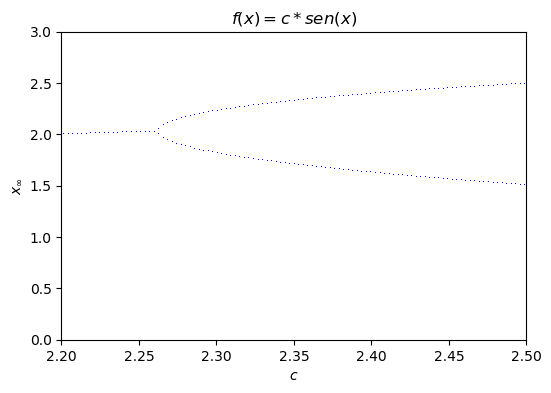

In [28]:
figure(figsize=(6,4))
plot(cc, ff, "b,")
xlabel(L"c")
ylabel(L"x_\infty")
xlim(2.2,2.5)
ylim(0,3)
title(L"f(x)=c*sen(x)")
show()

In [34]:
doblamiento_periodo(Sc,2.25:0.5^15:2.3,1)

2.2618408203125

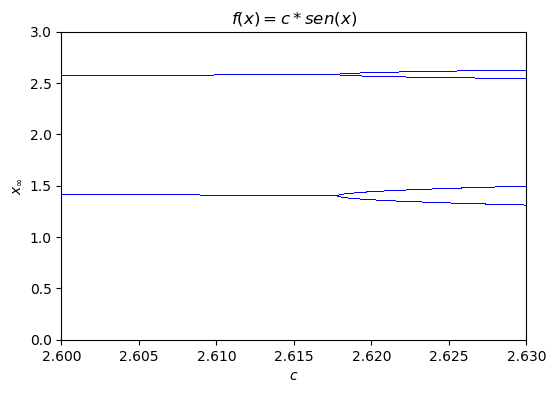

In [27]:
Sc(x,c)=c*sin(x)

crange = 1:1/7^5:3

ff = diag_bifurc(Sc, 10000, 256, crange); 
cc = ones(size(ff, 1)) * crange';
ff = reshape(ff, size(ff, 1)*size(ff, 2));
cc = reshape(cc, size(ff));

figure(figsize=(6,4))
plot(cc, ff, "b,")
xlabel(L"c")
ylabel(L"x_\infty")
xlim(2.6,2.63)
ylim(0,3)
title(L"f(x)=c*sen(x)")
show()

In [36]:
doblamiento_periodo(Sc,2.6:0.5^20:2.63,2)

2.617782211303711

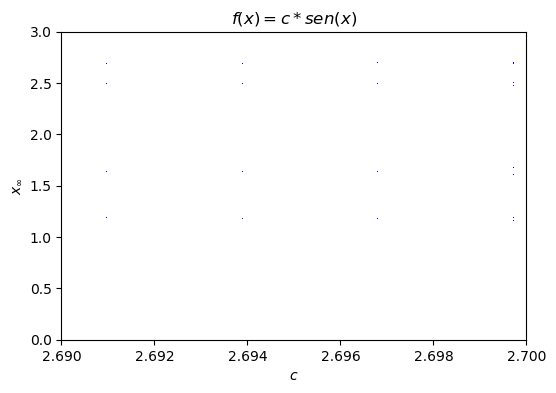

In [37]:
figure(figsize=(6,4))
plot(cc, ff, "b,")
xlabel(L"c")
ylabel(L"x_\infty")
xlim(2.69,2.7)
ylim(0,3)
title(L"f(x)=c*sen(x)")
show()

In [38]:
doblamiento_periodo(Sc,2.69:0.5^15:2.7,4)

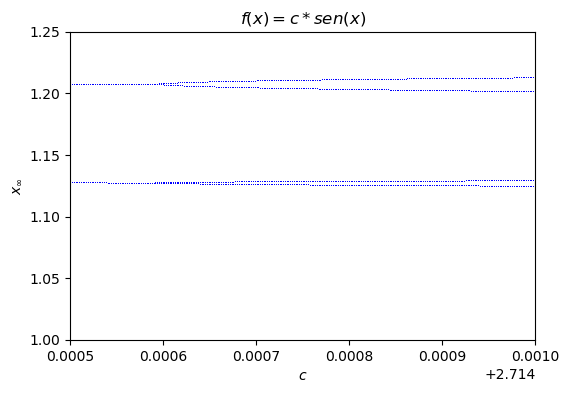

In [39]:
Sc(x,c)=c*sin(x)

crange = 2.7145:0.5^19:2.72

ff = diag_bifurc(Sc, 10000, 256, crange); 
cc = ones(size(ff, 1)) * crange';
ff = reshape(ff, size(ff, 1)*size(ff, 2));
cc = reshape(cc, size(ff));

figure(figsize=(6,4))
plot(cc, ff, "b,")
xlabel(L"c")
ylabel(L"x_\infty")
xlim(2.7145,2.715)
ylim(1,1.25)
title(L"f(x)=c*sen(x)")
show()

In [40]:
doblamiento_periodo(Sc,2.7145:0.5^17:2.715,8)

2.7146068115234376

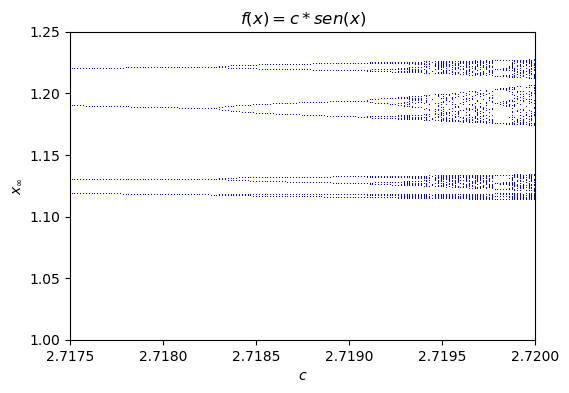

In [41]:
Sc(x,c)=c*sin(x)

crange = 2.71:0.5^16:2.73

ff = diag_bifurc(Sc, 10000, 256, crange); 
cc = ones(size(ff, 1)) * crange';
ff = reshape(ff, size(ff, 1)*size(ff, 2));
cc = reshape(cc, size(ff));

figure(figsize=(6,4))
plot(cc, ff, "b,")
xlabel(L"c")
ylabel(L"x_\infty")
xlim(2.7175,2.72)
ylim(1,1.25)
title(L"f(x)=c*sen(x)")
show()

In [42]:
doblamiento_periodo(Sc,2.718:0.5^25:2.7185,16)

2.718291049480438

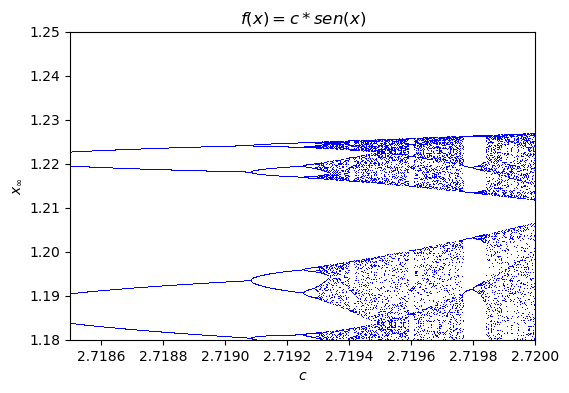

In [43]:
Sc(x,c)=c*sin(x)

crange = 2.718:0.5^19:2.72

ff = diag_bifurc(Sc, 10000, 256, crange); 
cc = ones(size(ff, 1)) * crange';
ff = reshape(ff, size(ff, 1)*size(ff, 2));
cc = reshape(cc, size(ff));

figure(figsize=(6,4))
plot(cc, ff, "b,")
xlabel(L"c")
ylabel(L"x_\infty")
xlim(2.7185,2.72)
ylim(1.18,1.25)
title(L"f(x)=c*sen(x)")
show()

In [44]:
doblamiento_periodo(Sc,2.719:0.5^25:2.7195,32)

2.7190818967819212

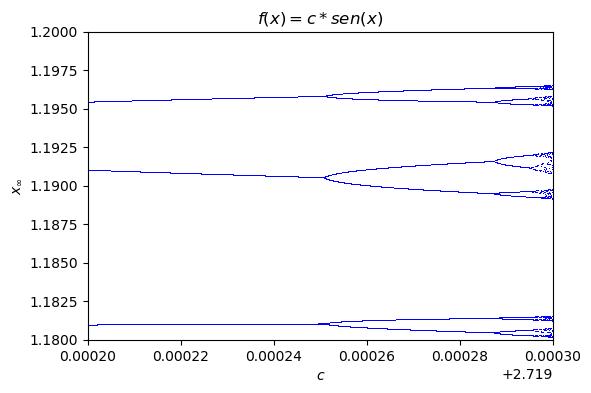

In [45]:
Sc(x,c)=c*sin(x)

crange = 2.719:0.5^24:2.72

ff = diag_bifurc(Sc, 10000, 256, crange); 
cc = ones(size(ff, 1)) * crange';
ff = reshape(ff, size(ff, 1)*size(ff, 2));
cc = reshape(cc, size(ff));

figure(figsize=(6,4))
plot(cc, ff, "b,")
xlabel(L"c")
ylabel(L"x_\infty")
xlim(2.7192,2.7193)
ylim(1.18,1.20)
title(L"f(x)=c*sen(x)")
show()

In [46]:
doblamiento_periodo(Sc,(2.719+0.00024):0.5^27:(2.719+0.00026),64)

2.7192537016177174

Entonces: 

$c_1=2.2606582641601562$

$c_2=2.617514228820801$

$c_3=2.697354736328125$

$c_4=2.7145991821289064$

$c_5=2.7182898573875427$

$c_6=2.719081717967987$

$c_7=2.719250952353477$

De igual modo, definimos la secuencia: $\{f_0, f_1, f_2, \dots\}$, donde:

\begin{equation}
f_n = \frac{c_n-c_{n+1}}{c_{n+1}-c_{n+2}} .
\end{equation}

In [47]:
C=[2.2606582641601562,2.617514228820801,2.697354736328125,2.7145991821289064,2.7182898573875427,2.719081717967987,2.719250952353477]

for i in 1:5
    A=fn(C[i],C[i+1],C[i+2])
    println(A)
end

4.469610424606944
4.629925973249084
4.672436503436281
4.660763964997322
4.679076170900375


Como se puede apreciar, esta familia de mapeos también converge al mismo límite. Al aumentar el número de puntos en el rango se obtienen resultados más precisos, pero también el tiempo que tarda en ejecutar los cálculos aumenta considerablemente.

## 3

Como se ve en la Fig. 1 del diagrama de bifurcaciones de $Q_c$, $x=0$ pertenece a un ciclo de periodo $2^n$ para ciertos valores $C_n$ del parámetro. Dichos valores son *especiales*, ya que el hecho de que $x=0$ pertenezca a un ciclo de periodo $2^n$ define los llamados *ciclos superestable*, donde tenemos $(Q^{2^p}_{C_n})'(0)=0$.

- ¿A qué converge la secuencia $f_n$, definida ahora a partir de los valores $C_n$.

- De los $2^p$ puntos del ciclo de periodo $2^p$, es decir, $\{0, p_1, \dots p_{2^{n-1}}\,\}$ hay uno (distinto del 0) cuya distancia a 0 es la menor; a esa distancia la identificaremos como $d_n$. Calcular numéricamente a qué converge la secuencia $d_n/d_{n+1}$.

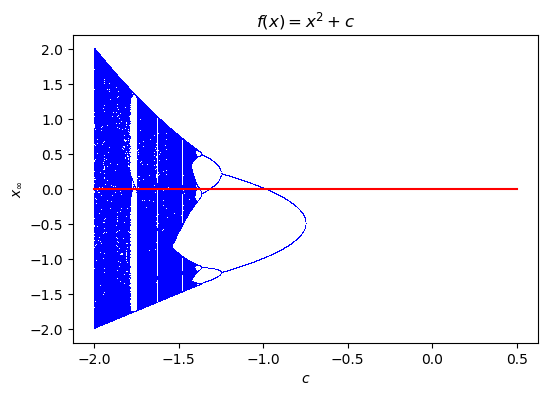

In [48]:
Qc(x,c) = x^2 + c

crange = -0.75:-1/2^10:-2.0

ff = diag_bifurc(Qc, 100000, 256, crange); 
cc = ones(size(ff, 1)) * crange';
ff = reshape(ff, size(ff, 1)*size(ff, 2));
cc = reshape(cc, size(ff));

figure(figsize=(6,4))
plot(cc, ff, "b,")
plot([-2,0.5], [0.0,0.0], "r-")
xlabel(L"c")
ylabel(L"x_\infty")
title(L"f(x)=x^2+c")
show()

In [49]:
"""Esta función encuentra en un intervalo c el parámetro para el cuál f(x) tiene una órbita súper estable (es decir, que 
el cero pertenece a esta órbita) de periodo p."""
function C_n(f,c,p;nit=1000000) 
        mapeo = diag_bifurc(f, nit, p, [c[1]])
        h0=1
        s=c[1]-c[2]
        for j in 1:p
            h=mapeo[j,1]
            if abs(h)<abs(h0)
                h0=h
            end
        end
        h1=h0
    for i in c
        mapeo = diag_bifurc(f, nit, p, [i])
        h0=1
        for j in 1:p
            h=mapeo[j,1]
            if abs(h)<abs(h0)
                h0=h
            end
        end
        if h1*h0<0
            return i+s
            break
        end
    end
end

C_n

In [50]:
C_n(Q,-0.90:-1/10^4:-1.24,2)

-1.0

In [51]:
C_n(Q,-1.25:-1/2^14:-1.35,4)

-1.3106689453125

In [52]:
C_n(Q,-1.3681:-1/2^15:-1.395,8)

-1.381527734375

In [53]:
C_n(Q,-1.395:-1/2^16:-1.3999,16)

-1.3969378662109375

In [54]:
C_n(Q,-1.3999:-1/2^17:-1.401,32)

-1.4002509521484374

In [55]:
C_n(Q,-1.401:-1/2^22:-1.402,64)

-1.4011137256622315

In [56]:
Cn=[-1,-1.3106689453125,-1.381527734375,-1.3969378662109375,-1.4002509521484374,-1.4011137256622315]
for i in 1:4
    A=fn(C[i],C[i+1],C[i+2])
    println(A)
end

4.469610424606944
4.629925973249084
4.672436503436281
4.660763964997322


$fn$ definida con los valores en los que $Q_c^p$ es super estable converge también a la constante $\delta$ de Feigenbaum

In [57]:
"""La función encuentra la distancia del x≠0 perteneciente a la órbita súperestable de periodo p de f(x) en el intervalo c
más cercano al 0"""
function d_n(f,c,p;nit=1000000) 
        mapeo = diag_bifurc(f, nit, p, [c[1]])
        h0=1
        s=c[1]-c[2]
        for j in 1:p
            h=mapeo[j,1]
            if abs(h)<abs(h0)
                h0=h
            end
        end
        h1=h0
    for i in c
        mapeo = diag_bifurc(f, nit, p, [i])
        h0=1
        for j in 1:p
            h=mapeo[j,1]
            if abs(h)<abs(h0)
                h0=h
            end
        end
        if h1*h0<0
            mapeo = diag_bifurc(f, nit, p, [i+s])
            H=[]
            for j in 1:p
            push!(H,abs(mapeo[j,1]))
            end
            H=sort(H)
            return(H[2])
            break
        end
    end
end

d_n

In [58]:
d_n(Q,-0.90:-1/10^4:-1.24,2)

1.0

In [59]:
d_n(Q,-1.25:-1/2^14:-1.35,4)

0.4071841299417698

In [60]:
d_n(Q,-1.3681:-1/2^15:-1.395,8)

0.16336815248402758

In [61]:
d_n(Q,-1.395:-1/2^16:-1.3999,16)

0.06532317928152831

In [62]:
d_n(Q,-1.3999:-1/2^17:-1.401,32)

0.026099990316489796

In [63]:
d_n(Q,-1.4011:-1/2^24:-1.402,64;nit=100000)

0.011566319937746705

In [65]:
dn=[1.0,0.4071841299417698,0.16336815248402758,0.06532317928152831,0.0260999903164897,0.011566319937746705]
for i in 1:4
    A=dn[i]/dn[i+1]
    println(A)
end

2.455891392778513
2.4924327278634064
2.5009216373248973
2.5028047324698743


Vemos que esta secuencia también converge a otra constante; la constante $\alpha$ de Feigenbaum, definida por:

$$ \alpha = lim_{n-> \infty} \frac{d_n}{d_{n+1}} = 2.5029078750958... $$

Que es otra constante universal para los sistemas dinámicos.